<a href="https://colab.research.google.com/github/MELAI-1/MY-PROJECT/blob/main/machine-learning/STEP_Study_Dropout_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dropout Regularization at Play**


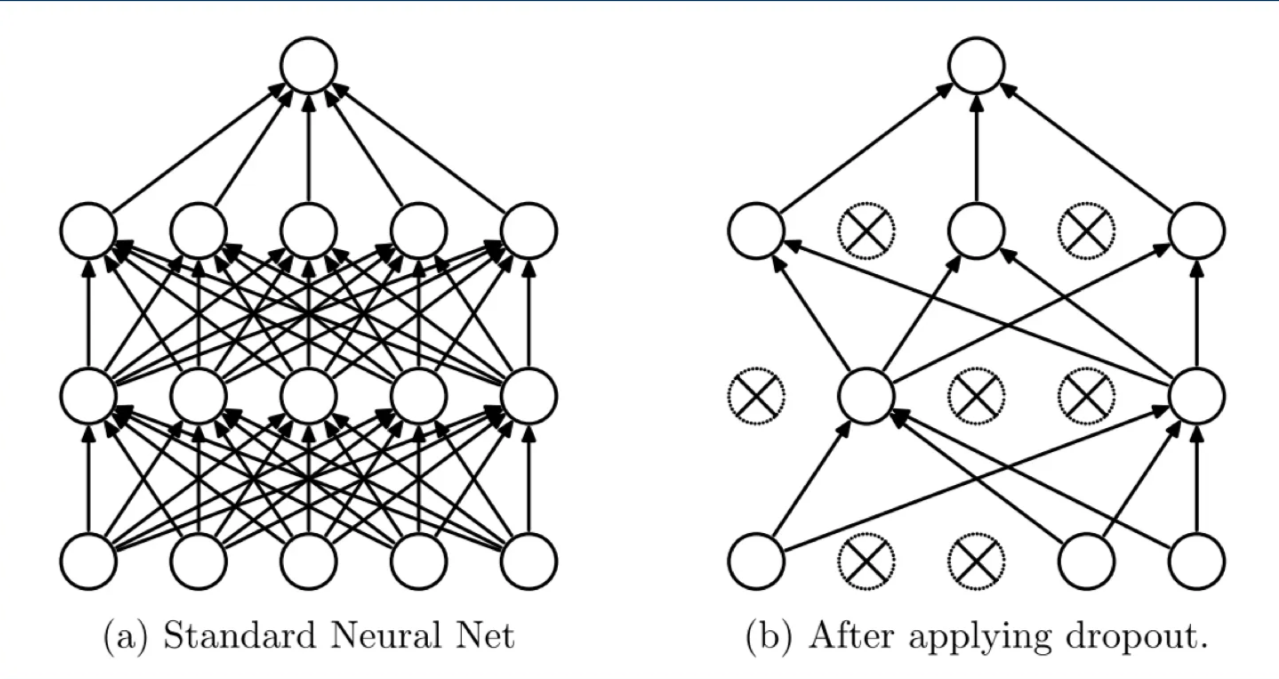

## I-Import Necessary Libraries

* **NumPy:** Provides powerful numerical computing tools and support for large
multi-dimensional arrays.

 * **Pandas:** Used for data manipulation and analysis, especially with tabular data through DataFrames.

* **Matplotlib**: A library for creating data visualizations like charts and plots.

* **TensorFlow:** A framework for building and training machine learning and deep learning models.

* **Keras (within TensorFlow):** A high-level API used for easily constructing neural networks.

* **MNIST dataset**: A standard dataset of handwritten digits used for training and testing image classification models.

* **to_categorical:** Utility to convert class labels into a categorical one-hot encoded format for classification models.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split

## import command-line tool : nvdia-smi

The `nvidia-smi` command is a command-line tool that allows real-time monitoring and management of the status, usage, and performance of NVIDIA graphics cards.


In [ ]:
 !nvidia-smi

Mon Sep 29 16:38:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## II-Import the dataset

In [ ]:
# Load the Fashion MNIST data
 (x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Samples from the Dataset

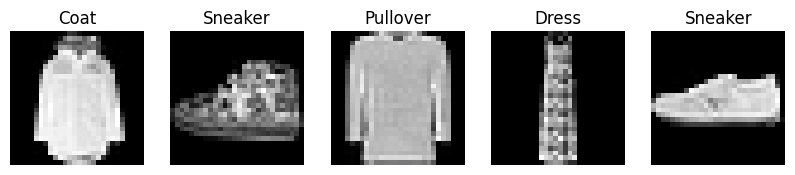

In [ ]:
# Fashion MNIST classes
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Display the first 5 images
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray')  # Fashion MNIST is grayscale
    plt.title(class_names[y_train[i]])
    plt.axis('off')
plt.show()


## III-Training data and Test data

* **ramdom_state** :  for reproducible results

In [ ]:
train_size = 0.2

x_train, x_unused, y_train, y_unused = train_test_split( x_train_full, y_train_full, train_size=train_size, random_state=42 )

# Check the size of the data
print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", x_test.shape)
print("Test labels shape:", y_test.shape)

Training data shape: (12000, 28, 28)
Training labels shape: (12000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)


## IV-Preprocess the Dataset


* Reshaping and normalizing the input data (scaling pixel values to the range 0-1)

* One-hot encoding the target labels (converting categorical labels to binary class matrices)

In [ ]:
X_train = x_train.reshape(-1, 28*28).astype('float32') / 255.0
X_test = x_test.reshape(-1, 28*28).astype('float32') / 255.0

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [ ]:
X_train.shape

(12000, 784)

In [ ]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [ ]:
y_train.shape

(12000, 10)

# V-Model Architecture

###Initialize Network Parameters

In [ ]:

# Initialize weights
def init_params():
    input_size = 28*28 #784
    hidden1 = 1024
    hidden2 = 512
    hidden3 = 256
    output_size = 10

    # He initialization

    W1 = np.random.randn(input_size, hidden1) * np.sqrt(2. / input_size)
    b1 = np.zeros((1, hidden1))

    W2 = np.random.randn(hidden1, hidden2) * np.sqrt(2. / hidden1)
    b2 = np.zeros((1, hidden2))

    W3 = np.random.randn(hidden2, hidden3) * np.sqrt(2. / hidden2)
    b3 = np.zeros((1, hidden3))

    W4 = np.random.randn(hidden3, output_size) * np.sqrt(2. / hidden3)
    b4 = np.zeros((1, output_size))

    return W1, b1, W2, b2, W3, b3, W4, b4



### help function

In [ ]:
#---Activation function and derivatives ---
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def softmax(x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))  # stability
    return exps / np.sum(exps, axis=1, keepdims=True)


In [ ]:
# --- Dropout ---
def apply_dropout(A, dropout_rate):
    mask = (np.random.rand(*A.shape) > dropout_rate).astype(float)
    return A * mask / (1.0 - dropout_rate), mask  # scale to keep expected value the same

In [ ]:
def cross_entropy(y_true, y_pred):
    eps = 1e-8
    return -np.mean(np.sum(y_true * np.log(y_pred + eps), axis=1))


In [ ]:
# def forward(X):
#     z1 = np.dot(X, W1) + b1
#     a1 = relu(z1)

#     z2 = np.dot(a1, W2) + b2
#     a2 = relu(z2)

#     z3 = np.dot(a2, W3) + b3
#     a3 = softmax(z3)

#     return z1, a1, z2, a2, z3, a3

In [ ]:
def forward(X, training=True, dropout_rate=0.5):
    z1 = np.dot(X, W1) + b1
    a1 = relu(z1)

    if training:
        a1, mask1 = apply_dropout(a1, dropout_rate)
    else:
        mask1 = None

    z2 = np.dot(a1, W2) + b2
    a2 = relu(z2)

    if training:
        a2, mask2 = apply_dropout(a2, dropout_rate)
    else:
        mask2 = None

    z3 = np.dot(a2, W3) + b3
    a3 = relu(z3)

    if training:
        a3, mask3 = apply_dropout(a3, dropout_rate)
    else:
        mask3 = None

    z4 = np.dot(a3, W4) + b4
    a4 = softmax(z4)

    return z1, a1, mask1, z2, a2, mask2, z3, a3, mask3, z4, a4


In [ ]:
# def backward(X, y_true, z1, a1, z2, a2, learning_rate=0.01):
#     global W1, b1, W2, b2
#     m = y_true.shape[0]


#     dz2 = a2 - y_true
#     dW2 = np.dot(a1.T, dz2) / m
#     db2 = np.sum(dz2, axis=0, keepdims=True) / m

#     da1 = np.dot(dz2, W2.T)
#     dz1 = da1 * relu_derivative(z1)
#     dW1 = np.dot(X.T, dz1) / m
#     db1 = np.sum(dz1, axis=0, keepdims=True) / m


#     W1 -= learning_rate * dW1
#     b1 -= learning_rate * db1
#     W2 -= learning_rate * dW2
#     b2 -= learning_rate * db2

In [ ]:
def backward(X, y_true, z1, a1, mask1, z2, a2, mask2, z3, a3, mask3, z4, a4, learning_rate=0.01, dropout_rate=0.5):
    m = y_true.shape[0]
    global W1, b1, W2, b2, W3, b3, W4, b4

    dz4 = a4 - y_true
    dW4 = np.dot(a3.T, dz4) / m
    db4 = np.sum(dz4, axis=0, keepdims=True) / m

    da3 = np.dot(dz4, W4.T)
    if mask3 is not None:
        da3 *= mask3 * (1.0 - dropout_rate)
    dz3 = da3 * relu_derivative(z3)
    dW3 = np.dot(a2.T, dz3) / m
    db3 = np.sum(dz3, axis=0, keepdims=True) / m

    da2 = np.dot(dz3, W3.T)
    if mask2 is not None:
        da2 *= mask2 * (1.0 - dropout_rate)
    dz2 = da2 * relu_derivative(z2)
    dW2 = np.dot(a1.T, dz2) / m
    db2 = np.sum(dz2, axis=0, keepdims=True) / m

    da1 = np.dot(dz2, W2.T)
    if mask1 is not None:
        da1 *= mask1 * (1.0 - dropout_rate)
    dz1 = da1 * relu_derivative(z1)
    dW1 = np.dot(X.T, dz1) / m
    db1 = np.sum(dz1, axis=0, keepdims=True) / m

    W4 -= learning_rate * dW4
    b4 -= learning_rate * db4
    W3 -= learning_rate * dW3
    b3 -= learning_rate * db3
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1

# VI-Training Without Dropout

In [ ]:
# def train(X, y, epochs=10, batch_size=64, learning_rate=0.01):
#     for epoch in range(epochs):
#         permutation = np.random.permutation(X.shape[0])
#         X_shuffled = X[permutation]
#         y_shuffled = y[permutation]

#         for i in range(0, X.shape[0], batch_size):
#             X_batch = X_shuffled[i:i+batch_size]
#             y_batch = y_shuffled[i:i+batch_size]

#             z1, a1, z2, a2 = forward(X_batch)
#             backward(X_batch, y_batch, z1, a1, z2, a2, learning_rate)

#         # Evaluate
#         _, _, _, preds = forward(X)
#         loss = cross_entropy(y, preds)
#         acc = np.mean(np.argmax(preds, axis=1) == np.argmax(y, axis=1))
#         print(f"Epoch {epoch+1}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")

In [ ]:
def train(X, y, epochs=300, batch_size=128, learning_rate=0.05, training= True, dropout_rate=0.5):
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }
    for epoch in range(epochs):
        permutation = np.random.permutation(X.shape[0])
        X_shuffled = X[permutation]
        y_shuffled = y[permutation]

        for i in range(0, X.shape[0], batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]

            z1, a1, m1, z2, a2, m2, z3, a3, m3, z4, a4 = forward(X_batch, training, dropout_rate=dropout_rate)
            backward(X_batch, y_batch, z1, a1, m1, z2, a2, m2, z3, a3, m3, z4, a4, learning_rate, dropout_rate)

        # Evaluate on full training set
        _, _, _, _, _, _, _, _, _, _, a4_train = forward(X, training=False)
        train_loss = cross_entropy(y, a4_train)
        train_acc = np.mean(np.argmax(a4_train, axis=1) == np.argmax(y, axis=1))

        # Evaluate on test set
        _, _, _, _, _, _, _, _, _, _, a4_test = forward(X_test, training=False)
        test_loss = cross_entropy(y_test, a4_test)
        test_acc = np.mean(np.argmax(a4_test, axis=1) == np.argmax(y_test, axis=1))


        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Test Loss : {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")



        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)

    return history

In [ ]:
def predict(X):
    _, _, _, _, _, _, _, _, _, _, probs = forward(X, training=False)
    return np.argmax(probs, axis=1)

In [ ]:
# train(X_train, y_train, epochs=20, batch_size=128, learning_rate=0.1)

# preds = predict(X_test)
# true = np.argmax(y_test, axis=1)
# test_acc = np.mean(preds == true)
# print("Test Accuracy:", test_acc)

## VI-Training WitH Dropout

In [ ]:


# --- Train the model ---
W1, b1, W2, b2, W3, b3, W4, b4 = init_params()
losses= train(X_train, y_train, epochs=150, learning_rate=0.05, training= False, dropout_rate=0.5)

# --- Evaluate on test data ---
preds = predict(X_test)
y_test_labels = np.argmax(y_test, axis=1)
test_acc = np.mean(preds == y_test_labels)
print("Test Accuracy:", test_acc)


Epoch 1, Train Loss: 0.7536, Train Accuracy: 0.7292, Test Loss : 0.7714, Test Accuracy: 0.7260
Epoch 2, Train Loss: 0.5508, Train Accuracy: 0.8141, Test Loss : 0.5853, Test Accuracy: 0.7931
Epoch 3, Train Loss: 0.4966, Train Accuracy: 0.8256, Test Loss : 0.5375, Test Accuracy: 0.8103
Epoch 4, Train Loss: 0.4612, Train Accuracy: 0.8410, Test Loss : 0.5112, Test Accuracy: 0.8229
Epoch 5, Train Loss: 0.4113, Train Accuracy: 0.8608, Test Loss : 0.4796, Test Accuracy: 0.8343
Epoch 6, Train Loss: 0.4072, Train Accuracy: 0.8573, Test Loss : 0.4810, Test Accuracy: 0.8286
Epoch 7, Train Loss: 0.3998, Train Accuracy: 0.8595, Test Loss : 0.4828, Test Accuracy: 0.8286
Epoch 8, Train Loss: 0.4143, Train Accuracy: 0.8474, Test Loss : 0.5001, Test Accuracy: 0.8242
Epoch 9, Train Loss: 0.3510, Train Accuracy: 0.8714, Test Loss : 0.4527, Test Accuracy: 0.8400
Epoch 10, Train Loss: 0.3253, Train Accuracy: 0.8830, Test Loss : 0.4307, Test Accuracy: 0.8465
Epoch 11, Train Loss: 0.3336, Train Accuracy: 0.8

KeyboardInterrupt: 

In [ ]:
print("The Dropout Regularization:")
# --- Train the model ---
W1, b1, W2, b2, W3, b3, W4, b4= init_params()
losses_drop= train(X_train, y_train, epochs=150, learning_rate=0.05, training= True, dropout_rate=0.5)

# --- Evaluate on test data ---
preds = predict(X_test)
y_test_labels = np.argmax(y_test, axis=1)
test_acc = np.mean(preds == y_test_labels)
print("Test Accuracy:", test_acc)

In [ ]:
# --- Use a clean and professional plot style ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# --- Plot 1: Model WITHOUT Dropout ---
ax1.plot(losses['train_acc'], label='Train Accuracy', color='royalblue')
ax1.plot(losses['test_acc'], label='Test Accuracy', color='darkorange')
# Fill the gap between train and test accuracy
ax1.fill_between(range(len(losses['train_acc'])),
                 losses['train_acc'],
                 losses['test_acc'],
                 color='royalblue', alpha=0.2, label='Overfitting Gap')
ax1.set_title('Without Dropout', fontsize=18)
ax1.set_xlabel('Epochs', fontsize=14)
ax1.set_ylabel('Accuracy', fontsize=14)
ax1.legend()
ax1.set_ylim(0.7, 1.0)

# --- Plot 2: Model WITH Dropout ---
ax2.plot(losses_drop['train_acc'], label='Train Accuracy', color='forestgreen')
ax2.plot(losses_drop['test_acc'], label='Test Accuracy', color='darkorange')
# Fill the gap between train and test accuracy
ax2.fill_between(range(len(losses_drop['train_acc'])),
                 losses_drop['train_acc'],
                 losses_drop['test_acc'],
                 color='forestgreen', alpha=0.2, label='Overfitting Gap')
ax2.set_title('With Dropout (p=0.5)', fontsize=18)
ax2.set_xlabel('Epochs', fontsize=14)
ax2.set_ylabel('Accuracy', fontsize=14)
ax2.legend()
ax2.set_ylim(0.7, 1.0)

# --- Add an overall title ---
fig.suptitle('Visualizing How Dropout Reduces the Overfitting Gap', fontsize=24, y=1.03)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [ ]:
# --- Use a clean and professional plot style ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=True) # sharey makes comparison easier

# ==================================
#    Plot 1: Loss WITHOUT Dropout
# ==================================
ax1.plot(losses['train_loss'], label='Train Loss', color='royalblue')
ax1.plot(losses['test_loss'], label='Test Loss', color='darkorange')

# Fill the gap between train and test loss to highlight overfitting
ax1.fill_between(range(len(losses['train_loss'])),
                 losses['train_loss'],
                 losses['test_loss'],
                 color='royalblue', alpha=0.2, label='Overfitting Gap')

ax1.set_title('Loss Without Dropout', fontsize=18)
ax1.set_xlabel('Epochs', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.legend(loc='upper right')
ax1.set_ylim(0, 0.8) # Set a consistent y-axis for direct comparison

# ==================================
#     Plot 2: Loss WITH Dropout
# ==================================
ax2.plot(losses_drop['train_loss'], label='Train Loss', color='forestgreen')
ax2.plot(losses_drop['test_loss'], label='Test Loss', color='darkorange')

# Fill the gap between train and test loss
ax2.fill_between(range(len(losses_drop['train_loss'])),
                 losses_drop['train_loss'],
                 losses_drop['test_loss'],
                 color='forestgreen', alpha=0.2, label='Overfitting Gap')

ax2.set_title('Loss With Dropout (p=0.5)', fontsize=18)
ax2.set_xlabel('Epochs', fontsize=14)
# ax2.set_ylabel('Loss', fontsize=14) # Not needed due to sharey=True
ax2.legend(loc='upper right')

# --- Add an overall title for the entire figure ---
fig.suptitle('Visualizing How Dropout Reduces the Loss Gap', fontsize=24, y=1.03)
plt.tight_layout(rect=[0, 0, 1, 0.97]) # Adjust layout to make space for suptitle
plt.show()

In [ ]:
# --- Plot the results ---
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(losses['train_acc'], label='Train Accuracy (No Dropout)', color='blue', linestyle='--')
plt.plot(losses['test_acc'], label='Test Accuracy (No Dropout)', color='orange', linestyle='--')
plt.plot(losses_drop['train_acc'], label='Train Accuracy (With Dropout)',color='blue' )
plt.plot(losses_drop['test_acc'], label='Test Accuracy (With Dropout)', color='orange')
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(losses['train_loss'], label='Train Loss (No Dropout)', color='blue', linestyle='--')
plt.plot(losses['test_loss'], label='Test Loss (No Dropout)', color='orange', linestyle='--')
plt.plot(losses_drop['train_loss'], label='Train Loss (With Dropout)', color='blue')
plt.plot(losses_drop['test_loss'], label='Test Loss (With Dropout)', color='orange')
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()